# **RedBull Sales and Marketing Analysis**
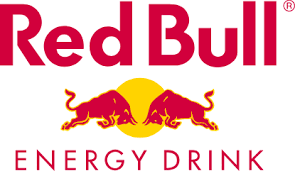

**Project Overview**  
This project analyzes sales and marketing data for RedBull using mock data generated through Mockaroo. The goal is to gain insights into customer behavior, product performance, and the effectiveness of marketing campaigns.  
  
The analysis is performed using SQL queries in a SQLite database, and some of the results are visualized using Python libraries like `matplotlib` and `seaborn`.

**Key Objectives**

1. ***Sales Analysis:***
   - Analyze sales by customer demographics (age, gender, location).
   - Identify top-performing products and sales trends over time.
   - Calculate average sales per customer.

2. ***Marketing Analysis:***
   - Evaluate the effectiveness of marketing campaigns by channel.
   - Measure sales lift generated by each campaign.

**Tools Used**
- **Mockaroo**: To generate mock sales and marketing data(csv files).
- **SQLite**: For database management and querying.
- **Pandas**: For data manipulation and analysis.
- **Matplotlib/Seaborn**: For data visualization.
- **Google Colab**: For running the notebook.

**Steps Covered**
1. **Data Loading**: Loaded CSV files into Pandas DataFrames.
2. **Database Setup**: Created SQLite tables and insert data.
3. **Data Cleaning**: Handled missing or invalid data.
4. **Analysis**: Executed SQL queries to extract insights.
5. **Visualization**: Created charts and graphs to represent some findings.

In [4]:
import pandas as pd
import sqlite3

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()

In [6]:
schema = """
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    age INT CHECK (age >= 18 AND age <= 100),
    gender TEXT CHECK (gender IN ('Male', 'Female', 'Other')),
    location TEXT
);

CREATE TABLE products (
    product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    category TEXT,
    price REAL CHECK (price > 0)
);

CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INT REFERENCES customers(customer_id) ON DELETE CASCADE,
    product_id INT REFERENCES products(product_id) ON DELETE CASCADE,
    sale_date DATE NOT NULL,
    quantity INT CHECK (quantity > 0) NOT NULL
);

CREATE TABLE marketing_campaigns (
    campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
    channel TEXT CHECK (channel IN ('Social Media', 'TV', 'Radio', 'Print')),
    start_date DATE NOT NULL,
    end_date DATE NOT NULL CHECK (end_date > start_date),
    budget REAL CHECK (budget > 0),
    sales_lift INT CHECK (sales_lift >= 0)
);
"""

# Execute the schema
cursor.executescript(schema)
conn.commit()

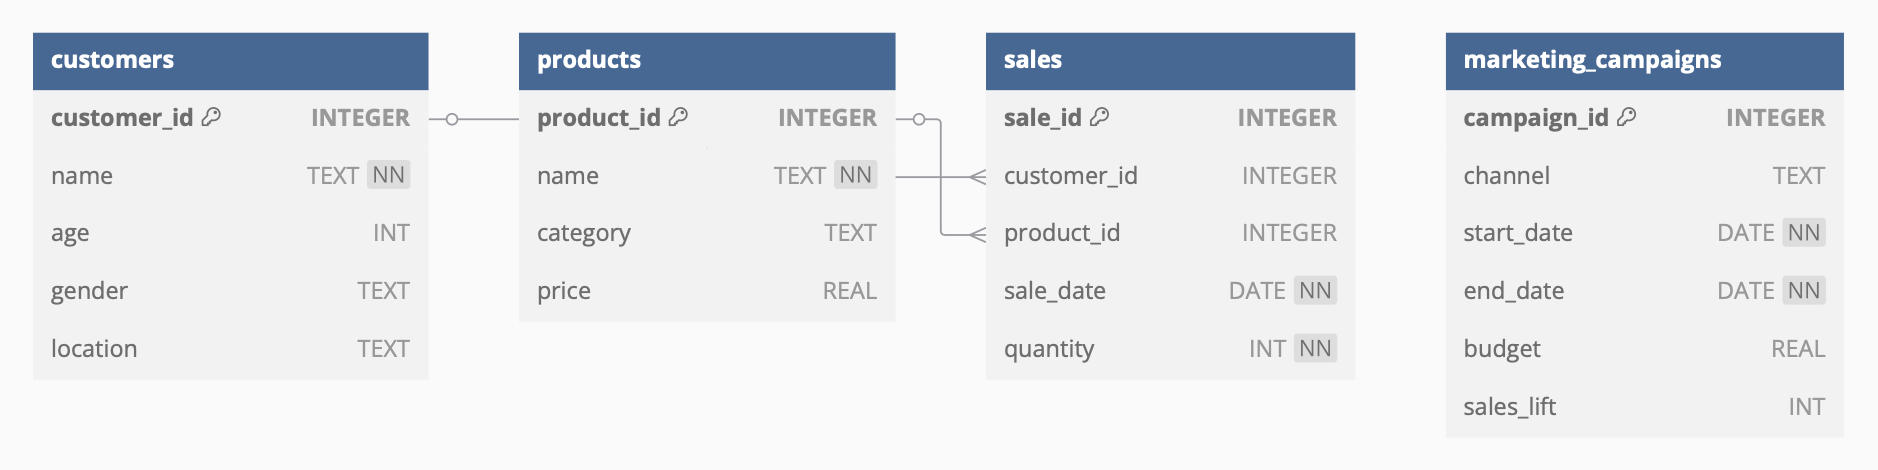

In [7]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

[('customers',), ('sqlite_sequence',), ('products',), ('sales',), ('marketing_campaigns',)]


In [9]:
customers_df = pd.read_csv('/content/customers.csv')
products_df = pd.read_csv('/content/products.csv')
sales_df = pd.read_csv('/content/sales.csv')
marketing_campaigns_df = pd.read_csv('/content/marketing_campaigns.csv')

In [10]:
customers_df.to_sql('customers', conn, if_exists='append', index=False)
products_df.to_sql('products', conn, if_exists='append', index=False)
sales_df.to_sql('sales', conn, if_exists='append', index=False)
marketing_campaigns_df.to_sql('marketing_campaigns', conn, if_exists='append', index=False)

50

# **Sales Analysis**

**1. Total Sales by Customer Age Group**  
This query groups customers into age brackets and calculates the total sales for each group. It helps identify which age group contributes the most to sales.

In [11]:
query1 = """
SELECT CASE
            WHEN c.age < 18 THEN 'Under 18'
            WHEN c.age BETWEEN 18 AND 24 THEN '18-24'
            WHEN c.age BETWEEN 25 AND 34 THEN '25-34'
            WHEN c.age BETWEEN 35 AND 44 THEN '35-44'
            WHEN c.age BETWEEN 45 AND 54 THEN '45-54'
            ELSE '55+'
        END AS age_group,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales AS s
JOIN Customers AS c ON s.customer_id = c.customer_id
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY age_group
ORDER BY total_sales DESC;
"""
result1 = pd.read_sql(query1, conn)
print(result1)

  age_group  total_sales
0       55+    2546.7296
1     45-54    1925.4201
2     35-44    1820.5525
3     25-34    1731.8526
4     18-24    1252.6763


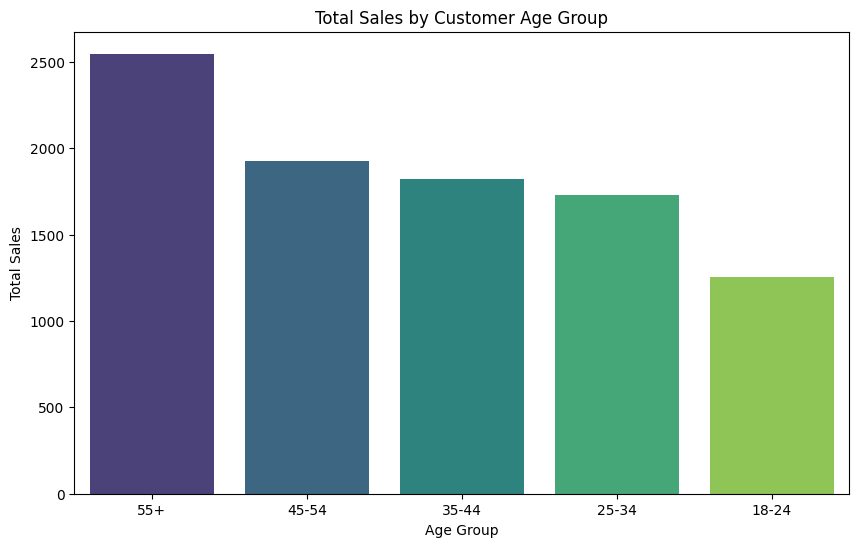

In [14]:
#visualisation

plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='total_sales', data=result1, hue='age_group', palette='viridis', legend=False)
plt.title('Total Sales by Customer Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Sales')
plt.show()

**2.Total Sales by Customer Gender**  
This query calculates total sales by gender. It helps understand which gender drives more sales.

In [15]:
query2 = """
SELECT c.gender,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales AS s
JOIN Customers AS c ON s.customer_id = c.customer_id
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY c.gender
ORDER BY total_sales DESC;
"""
result2 = pd.read_sql(query2, conn)
print(result2)

   gender  total_sales
0   Other    3252.5114
1  Female    3115.1493
2    Male    2909.5704


**3.Total Sales by Customer Location**  
This query calculates total sales by customer location. It helps identify high-performing regions.

In [17]:
query3 = """
SELECT c.location,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales s
JOIN Customers c ON s.customer_id = c.customer_id
JOIN Products p ON s.product_id = p.product_id
GROUP BY c.location
ORDER BY total_sales DESC;
"""
result3 = pd.read_sql(query3, conn)
print(result3)

       location  total_sales
0       Gandara     121.1287
1         Meipu     107.7490
2       Alfenas      90.6462
3       Talisay      86.4187
4         Baimi      82.3824
..          ...          ...
307     Ilinden       3.3695
308        Agoo       3.3000
309   Gayamsari       2.9505
310  Xiaopingba       2.8290
311        Ōita       2.6429

[312 rows x 2 columns]


**4.Products with the Highest Sales Quantity**  
This query identifies the top-selling products by quantity. It helps in inventory planning and marketing strategies.

In [20]:
query4 = """
SELECT
       p.name AS product_name,
       SUM(s.quantity) AS total_quantity_sold
FROM Sales s
JOIN Products p ON s.product_id = p.product_id
GROUP BY p.name
ORDER BY total_quantity_sold DESC;


"""
result4 = pd.read_sql(query4, conn)
print(result4)

            product_name  total_quantity_sold
0          Red Bull Zero              1595.29
1    Red Bull Sugar Free              1506.58
2      Red Bull Tropical              1138.50
3  Red Bull Energy Drink               848.79
4  Red Bull Blue Edition               315.77


**5.Average Sales per Customer and Group by Average Value**  
This query calculates the average sales value per customer and then groups customers who have the same average sales value. It helps identify patterns in customer purchasing behavior, such as whether certain customers consistently spend similar amounts.

In [21]:
query5 = """

WITH customer_averages AS (
    SELECT c.customer_id,
           c.name AS customer_name,
           AVG(s.quantity * p.price) AS average_sale_value
    FROM Sales AS s
    JOIN Customers AS c ON s.customer_id = c.customer_id
    JOIN Products AS p ON s.product_id = p.product_id
    GROUP BY c.customer_id
)
SELECT average_sale_value,
       GROUP_CONCAT(customer_name, ', ') AS customer_names,
       COUNT(customer_name) AS customer_count
FROM customer_averages
GROUP BY average_sale_value
ORDER BY average_sale_value DESC;

"""
result5 = pd.read_sql(query5, conn)
print(result5)

     average_sale_value     customer_names  customer_count
0               49.2024    Itch Woodington               1
1               47.2230         Suzy Kelso               1
2               46.7622      Petey Gasking               1
3               40.9760    Kasper Trevance               1
4               40.8096     Addison Malser               1
..                  ...                ...             ...
313              3.3695      Abigail Peach               1
314              3.3000  Bartolomeo Tether               1
315              2.9505      Earle Lidgett               1
316              2.8290    Junette Pomeroy               1
317              2.6429     Viviana Myrick               1

[318 rows x 3 columns]


**6.Total Sales by Month**  
This query calculates total sales by month. It helps identify seasonal trends.

In [27]:
query6 = """

SELECT strftime('%Y-%m', s.sale_date) AS month,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales AS s
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY month
ORDER BY month;

"""
result6 = pd.read_sql(query6, conn)
print(result6)

      month  total_sales
0   2024-01    1716.5822
1   2024-02    1324.1795
2   2024-03    1290.4716
3   2024-04    1528.6668
4   2024-05    1679.5225
5   2024-06    1163.5620
6   2024-07    1582.6617
7   2024-08    1715.2043
8   2024-09    1758.7729
9   2024-10    1643.7491
10  2024-11    1784.9992
11  2024-12    1570.6748


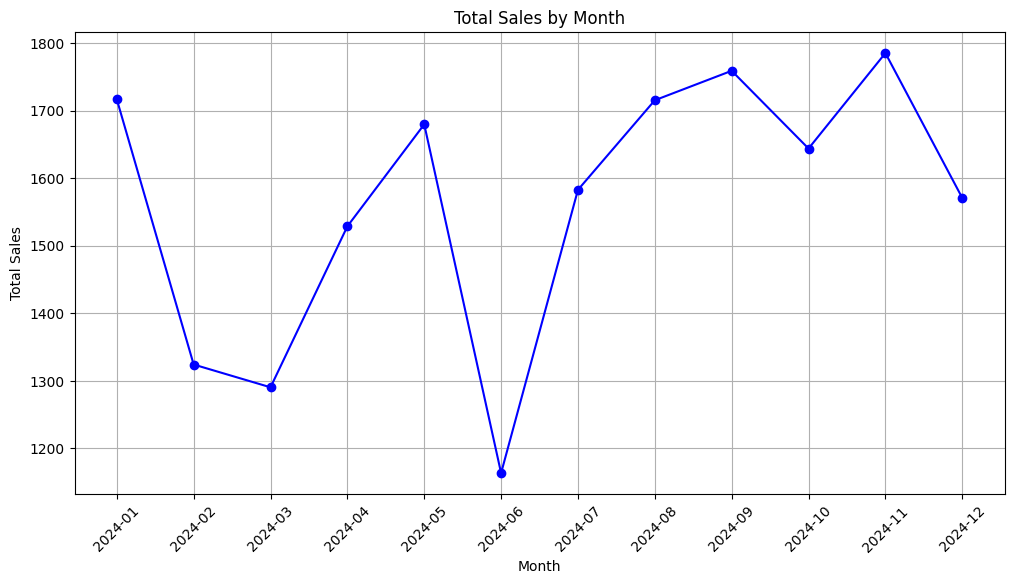

In [28]:
#visualisation

plt.figure(figsize=(12, 6))
plt.plot(result6['month'], result6['total_sales'], marker='o', linestyle='-', color='b')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**7.Total Sales by Product**  
This query calculates total sales by product. It helps identify the most profitable products.

In [29]:
query7 = """
SELECT p.name,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales AS s
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY p.name
ORDER BY total_sales DESC;

"""
result7 = pd.read_sql(query7, conn)
print(result7)

                    name  total_sales
0          Red Bull Zero    5432.5798
1    Red Bull Sugar Free    5146.4119
2      Red Bull Tropical    4175.2202
3  Red Bull Energy Drink    3038.5785
4  Red Bull Blue Edition     966.2562


# **Marketing Analysis Queries**

**1.Sales Lift by Marketing Channel**  
This query calculates the total sales and sales lift generated by each marketing channel. It helps evaluate the effectiveness of different channels.

In [33]:
query8 = """
SELECT
    m.channel,
    SUM(s.quantity * p.price) AS total_sales,
    SUM(m.sales_lift) AS total_sales_lift
FROM marketing_campaigns AS m
JOIN Sales AS s ON s.sale_date BETWEEN m.start_date AND m.end_date
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY m.channel
ORDER BY total_sales_lift DESC;

"""
result8 = pd.read_sql(query8, conn)
print(result8)

        channel  total_sales  total_sales_lift
0  Social Media  100230.2599            249336
1            TV   71531.1032            170468
2         Print   48725.0970             83051


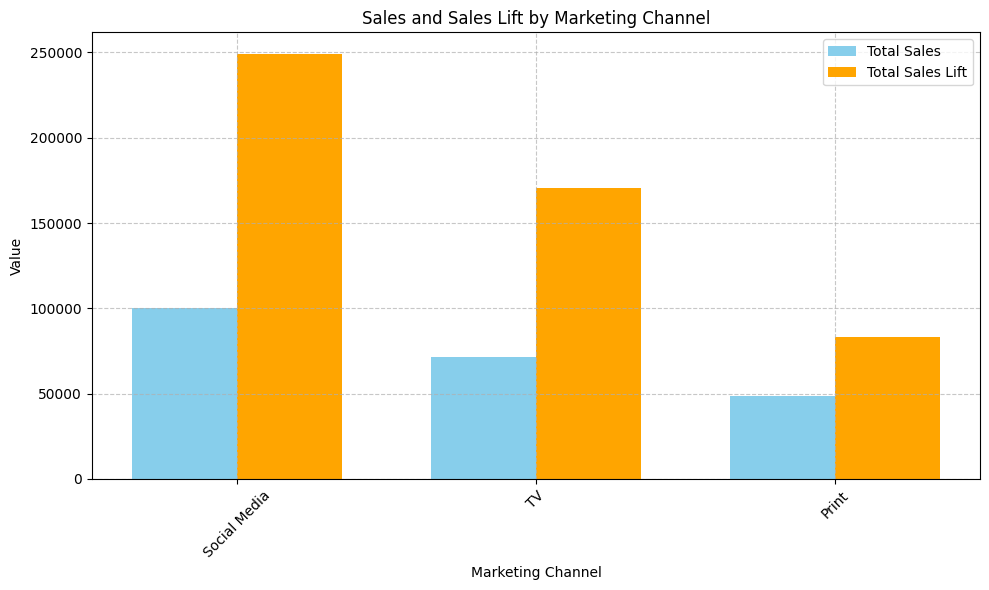

In [39]:
# visualisation

plt.figure(figsize=(10, 6))

# total_sales and total_sales_lift for each channel
bar_width = 0.35
index = range(len(result8['channel']))

# total_sales
plt.bar(index, result8['total_sales'], width=bar_width, label='Total Sales', color='skyblue')

# total_sales_lift (next to total_sales)
plt.bar([i + bar_width for i in index], result8['total_sales_lift'], width=bar_width, label='Total Sales Lift', color='orange')

# labels, title, and legend
plt.xlabel('Marketing Channel')
plt.ylabel('Value')
plt.title('Sales and Sales Lift by Marketing Channel')
plt.xticks([i + bar_width / 2 for i in index], result8['channel'], rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**2.Total Sales by Marketing Campaign Channel**  
This query calculates total sales by marketing channel. It helps identify the most effective channels.

In [34]:
query9 = """
SELECT m.channel,
       SUM(s.quantity * p.price) AS total_sales
FROM Sales AS s
JOIN marketing_campaigns AS m ON s.sale_date BETWEEN m.start_date AND m.end_date
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY m.channel
ORDER BY total_sales DESC;

"""
result9 = pd.read_sql(query9, conn)
print(result9)

        channel  total_sales
0  Social Media  100230.2599
1            TV   71531.1032
2         Print   48725.0970


**3.Sales Lift After Marketing Campaigns**  
This query calculates the sales lift generated by each campaign. It helps measure the ROI of marketing efforts.

In [40]:
query10 = """
SELECT m.channel,
       m.campaign_id,
       SUM(s.quantity * p.price) AS total_sales_after_campaign,
       m.sales_lift
FROM Sales AS s
JOIN marketing_campaigns AS m ON s.sale_date BETWEEN m.start_date AND m.end_date
JOIN Products AS p ON s.product_id = p.product_id
GROUP BY m.channel, m.campaign_id
ORDER BY m.sales_lift DESC;


"""
result10 = pd.read_sql(query10, conn)
print(result10)

         channel  campaign_id  total_sales_after_campaign  sales_lift
0   Social Media           12                   4374.3593         100
1   Social Media            2                   5002.1282          99
2   Social Media           29                   5569.3562          96
3             TV           21                   4993.7472          92
4   Social Media           45                   3040.6282          92
5             TV            3                   4266.1118          84
6          Print           27                   2926.1249          81
7   Social Media           50                   4879.3533          81
8             TV           26                   5116.7623          79
9   Social Media           24                   4166.6254          74
10            TV           40                   3913.8060          74
11         Print           38                   4412.7359          73
12            TV           22                   2245.6158          69
13  Social Media    

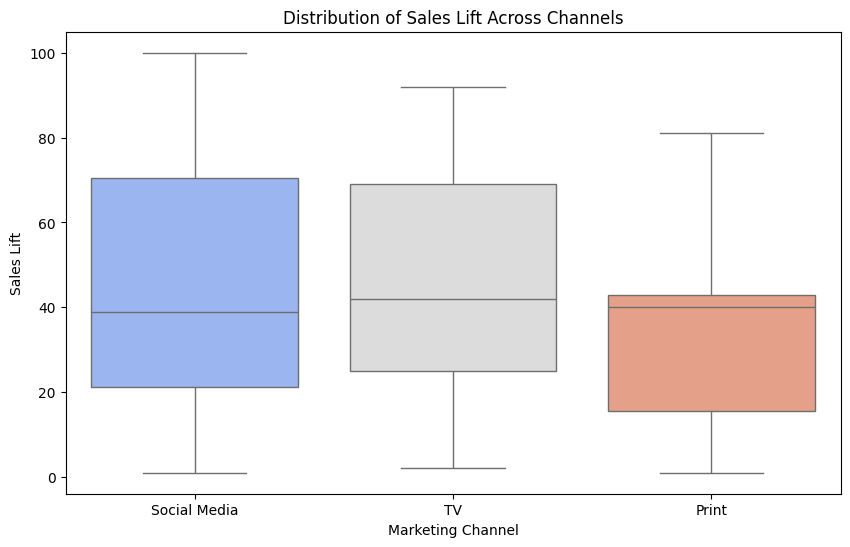

In [47]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=result10, x="channel", y="sales_lift", hue="channel", palette="coolwarm", legend=False)

plt.xlabel("Marketing Channel")
plt.ylabel("Sales Lift")
plt.title("Distribution of Sales Lift Across Channels")
plt.show()